Begun 12/3/2024

Revisiting this test to make sure that our w2 factor is correct. Our null test looking at differences of the estimator between different arrays has been failing the chi2 PTE distribution test (an excess of maps with PTE<0.1), and Steve is concerned that this might be due to the differences in simulated and theoretical variance that we were seeing in the previous bincount notebooks. Those tests usually found that the variance measured from a large number of signal-only sims in a realistic depth-1 mask was lower than the theoretical variance as calculated from 2\*C_ell\*\*2 / nu_b (where nu_b is the number of modes multiplied by the w2 factor to account for the reduced number of modes from the mask).

In this notebook, I want to make the test more realistic to the values of ell that we use. Since it is a signal-only set of sims, there is no ivar-weighting, filtering or filtering transfer function, or galaxy mask. Last time, I was looking at an ell range of 25-5000 with bins of 25, but in reality we only care about 500 (or 700) to 2500 in bins of 200. I will start by testing that for one map that passes our data cuts for 1000 sims and then see if there is anything else that needs to be tried (perhaps realistic beams?) to test w2 vs w2w4 vs Steve's empirical correction factor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
keys_eshow = {"downgrade": 4, "ticks": 5, "colorbar": True, "font_size": 40}

def eshow(x,**kwargs): 
    ''' Function to plot the maps for debugging '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "auto")

# Functions for calculating power spectra from depth-1 and reference map to use as noise in sims
# Confirmed that these match what is in axion_osc_analysis_depth1_ps.py on 12/3/24
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

In [4]:
# Generating test pixell map in same shape as a depth-1 map
# Grabbing our new list with more maps in case I want to test more of the ones that fail the PTE test
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_w_second_batch_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

In [5]:
# In case I want to test this skyarea function
def get_hivon_fsky_enmap(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi)*w2w4
    return skyarea

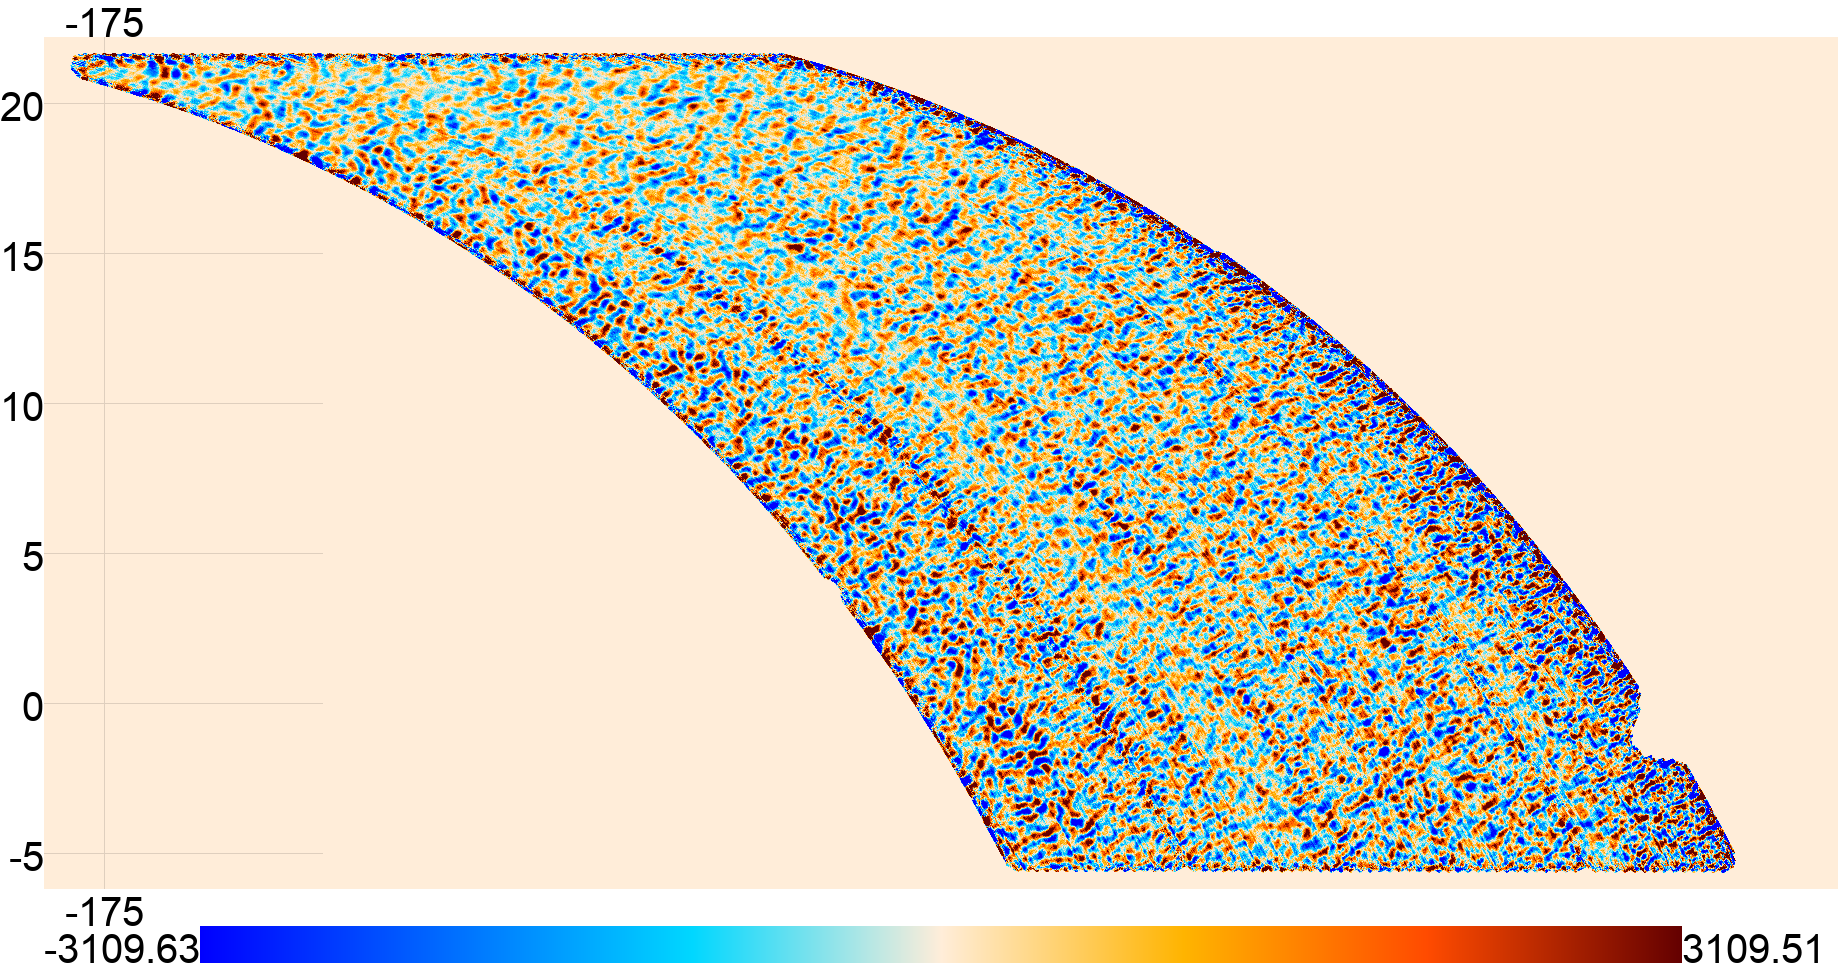

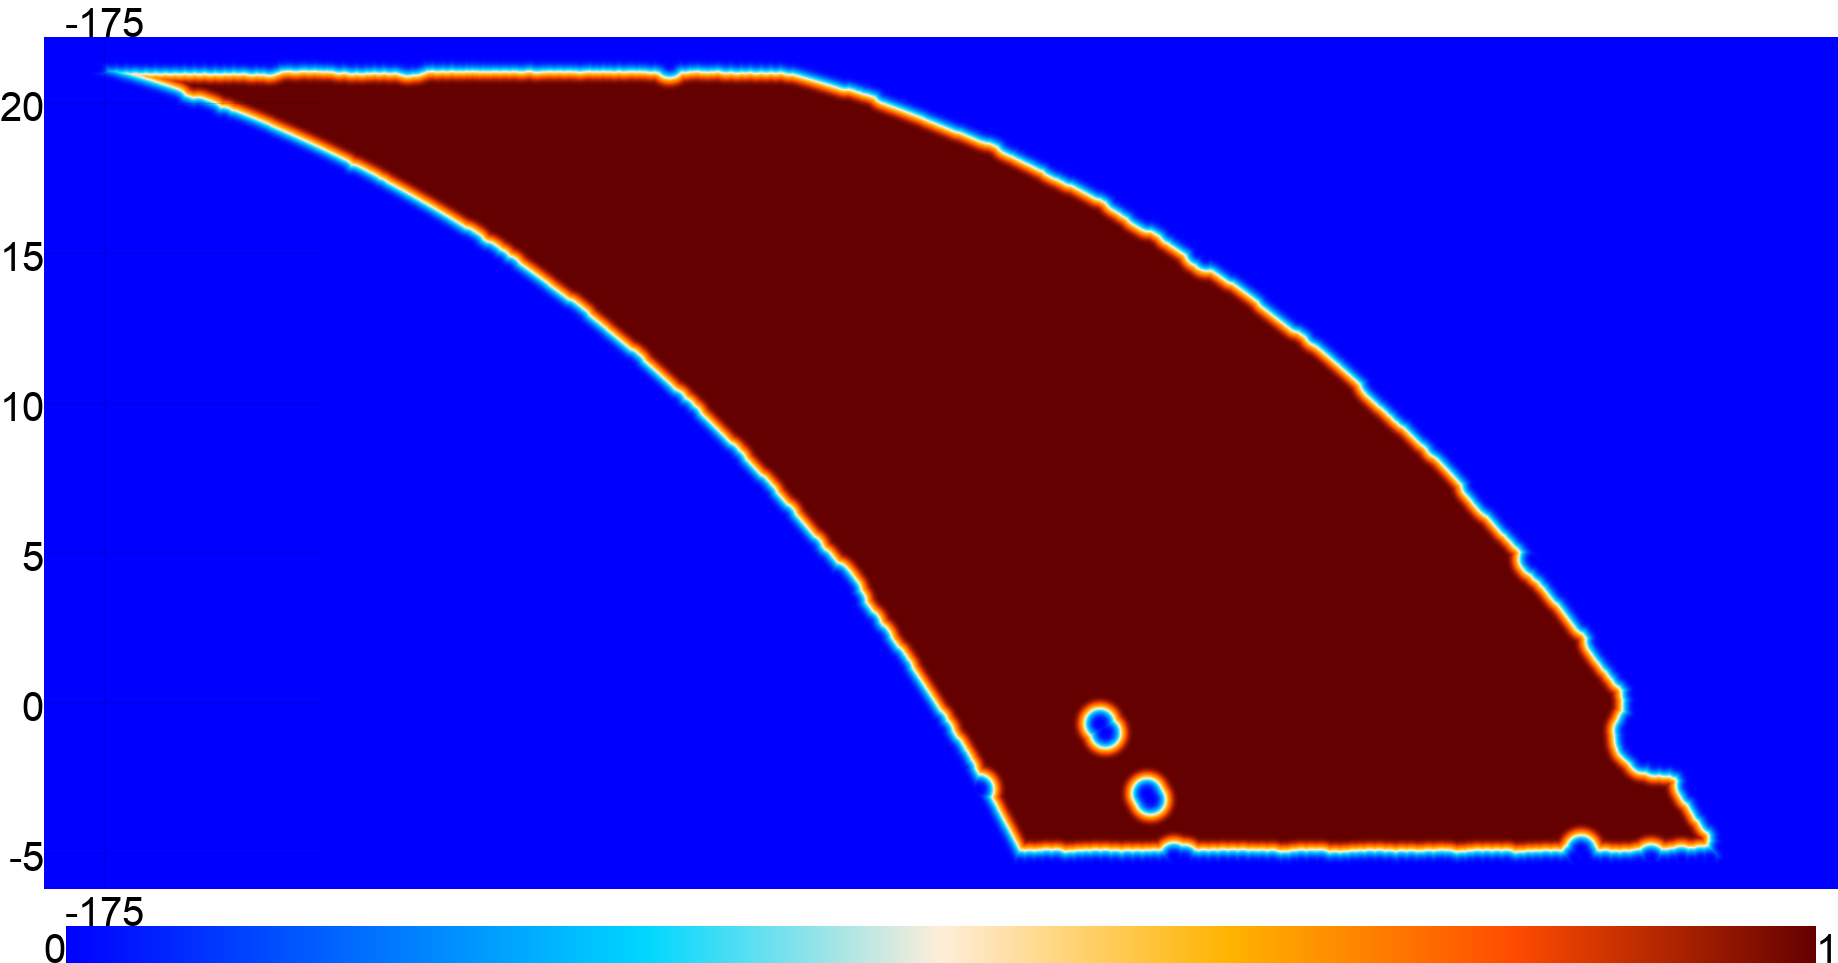

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [7:19:57<00:00,  5.28s/it]


Map name: depth1_1494463440_pa4_f150_map.fits
w2: 0.33581580180667353
w2w4: 0.34284425609329683
f_sky w/w2w4: 0.013837504089267325


In [14]:
# For one of the depth-1 masks, generate pixell sims using alm from CAMB to compare
# the measured variance to the theoretical variance

# ell range 500-2500, bin size of 200, 5000 sims

indices = [0] # which depth-1 maps to use - testing a single map first
for idx in indices:
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_T = enmap.read_map(depth1_path)[0]
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 1.0*enmap.read_map(ivar_path) # 1.0 for T noise - shouldn't matter here; we just want the ivar shape
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)
    
    eshow(depth1_T, **keys_eshow)
    eshow(depth1_mask, **keys_eshow)
    
    w2 = np.mean(depth1_mask**2)
    w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
    
    N_sims = 5000
    lmin = 500
    lmax = 2501
    bin_size = 200
    
    bins = np.arange(lmin, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.0
    
    spectra = []
    spectra_w2w4 = []
    
    for i in tqdm(range(N_sims)):
        alm = hp.sphtfunc.synalm(ClTT)
        input_map = curvedsky.alm2map(alm, depth1_T, spin=[0])
        fourier_map = enmap.map2harm(input_map*depth1_mask,normalize='phys')
        binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                             b_ell_bin_2=1.0, w2=w2, bins=bins)
        binned_TT_w2w4, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                             b_ell_bin_2=1.0, w2=w2w4, bins=bins)
        spectra.append(binned_TT)
        spectra_w2w4.append(binned_TT_w2w4)
        
    spectra = np.array(spectra)
    spectra_w2w4 = np.array(spectra_w2w4)
    variance = np.var(spectra,axis=0)
    mean = np.mean(spectra, axis=0)
    variance_w2w4 = np.var(spectra_w2w4,axis=0)
    mean_w2w4 = np.mean(spectra_w2w4, axis=0)
    
    # binning CAMB input to match my spectra
    digitized = np.digitize(ell[2:], bins, right=True)
    CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    
    theory_var = 2*CAMB_ClTT_binned**2/(bincount*w2)
    theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(bincount*w2w4)
    
    f_sky = get_hivon_fsky_enmap(depth1_mask)
    
    print("Map name: " + lines[idx])
    print("w2: " + str(w2))
    print("w2w4: " + str(w2w4))
    print("f_sky w/w2w4: " +str(f_sky))

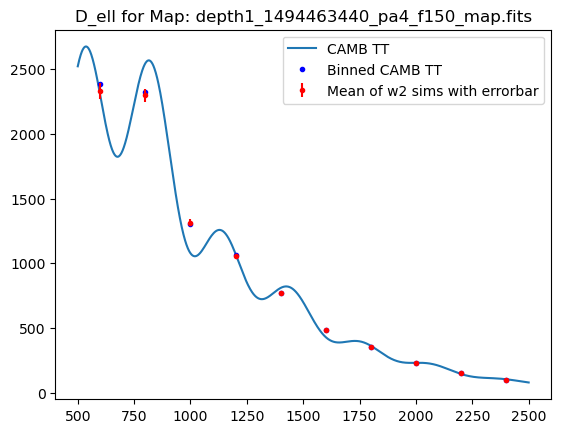

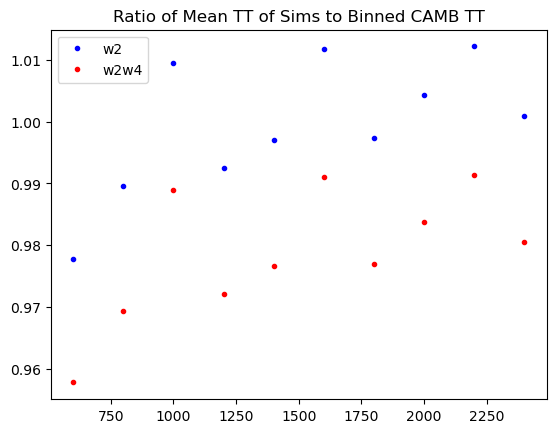

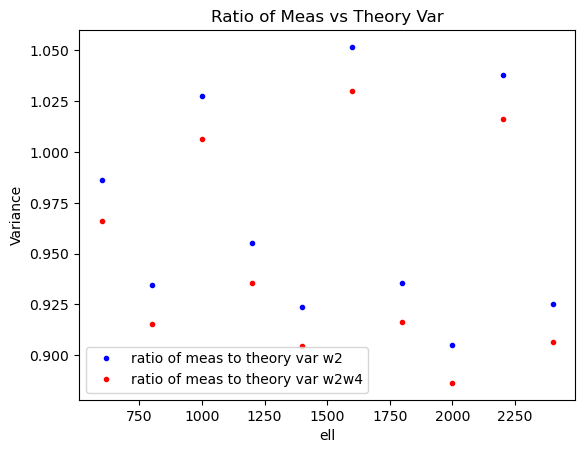

In [16]:
plt.plot(ell[500:2501],ell[500:2501]*(ell[500:2501]+1)*ClTT[500:2501]/(2*np.pi),label='CAMB TT')
plt.plot(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'b.',label='Binned CAMB TT')
plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of w2 sims with errorbar')
plt.title("D_ell for Map: " + lines[idx])
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(centers,mean/CAMB_ClTT_binned,'b.',label='w2')
plt.plot(centers,mean_w2w4/CAMB_ClTT_binned,'r.',label='w2w4')
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.legend()
plt.show()
plt.close()

plt.plot(centers,variance/theory_var,'b.',label='ratio of meas to theory var w2')
plt.plot(centers,variance_w2w4/theory_var_w2w4,'r.',label='ratio of meas to theory var w2w4')
plt.legend()
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [5:54:30<00:00,  4.25s/it]

Map name: depth1_1494463440_pa4_f150_map.fits
Empirical correction factor:  0.01352558997450285
w2 for healpix full sky: 0.01357861109780112
w2w4 for healpix full sky: 0.013860629508294761


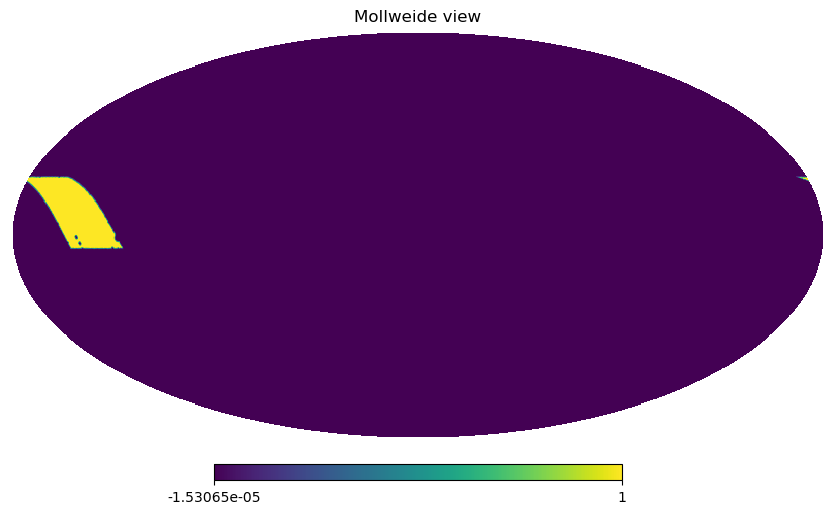

In [48]:
# Now generating the pseudo-Cl PS correction factor from Steve's sensitivity notebook
# Basically just taking the average of the ratio between the simulated healpix spectrum with the mask
# and the input ClTT
# Going to do everything in healpix for this first, then will figure out how to do it in pixell

NSIDE=1024

indices = [0] # which depth-1 maps to use - testing a single map first
for idx in indices:
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_T = enmap.read_map(depth1_path)[0]
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 1.0*enmap.read_map(ivar_path) # 1.0 for T noise - shouldn't matter here; we just want the ivar shape
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)
    
    healpy_mask = reproject.map2healpix(depth1_mask,nside=NSIDE)
    hp.mollview(healpy_mask)
    
    # Steve's empirical correction factor from a quick healpix sim
    tmp_m = hp.synfast(ClTT,nside=NSIDE)
    tmp_cl = hp.anafast(tmp_m*healpy_mask)
    corr_factor = np.mean(tmp_cl[2:]/ClTT[2:len(tmp_cl)])
    
    w2 = np.mean(healpy_mask**2)
    w2w4 = np.mean(healpy_mask**2)**2 / np.mean(healpy_mask**4)
    
    N_sims = 5000
    lmin = 500
    lmax = 1901
    bin_size = 200
    
    bins = np.arange(lmin, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.0
    
    spectra = []

    # binning CAMB input to match my spectra
    digitized = np.digitize(ell[lmin:lmax+1], bins, right=True)
    CAMB_ClTT_binned = np.bincount(digitized, ClTT[lmin:lmax+1].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    
    for i in tqdm(range(N_sims)):
        alm = hp.sphtfunc.synalm(ClTT)
        input_map = hp.sphtfunc.alm2map(alm, nside=NSIDE, pol=False)
        full_spectrum = hp.sphtfunc.anafast(input_map*healpy_mask) / corr_factor
        binned_TT = np.bincount(digitized, full_spectrum[lmin:lmax+1].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
        spectra.append(binned_TT)
        
    spectra = np.array(spectra)
    variance = np.var(spectra,axis=0)
    mean = np.mean(spectra, axis=0)
    
    theory_bincount_w_fsky = (2*centers + 1)*bin_size
    theory_var = 2*CAMB_ClTT_binned**2/(theory_bincount_w_fsky*corr_factor)
    
    print("Map name: " + lines[idx])
    print("Empirical correction factor: ", corr_factor)
    print("w2 for healpix full sky: " + str(w2))
    print("w2w4 for healpix full sky: " + str(w2w4))

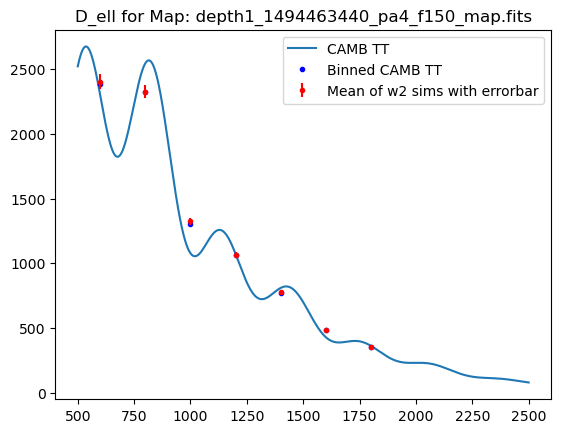

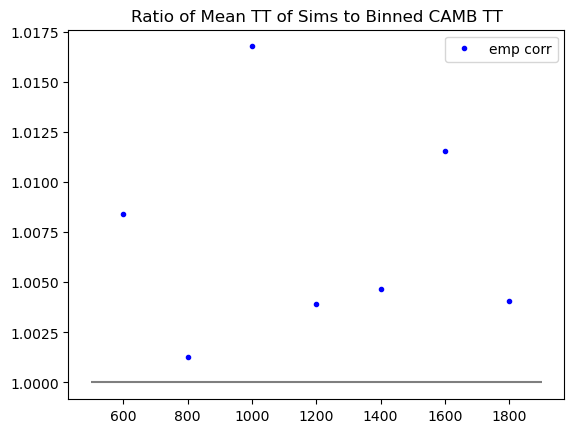

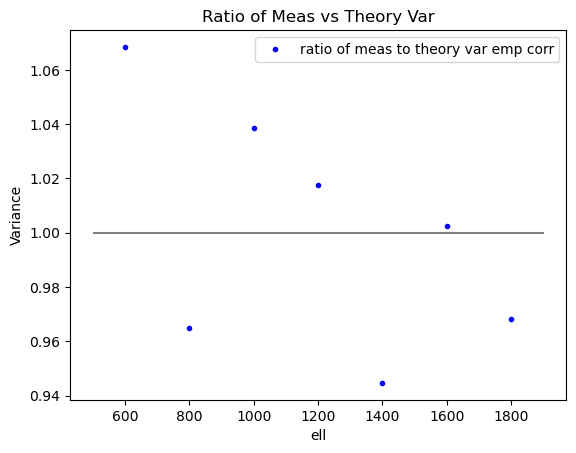

In [49]:
plt.plot(ell[500:2501],ell[500:2501]*(ell[500:2501]+1)*ClTT[500:2501]/(2*np.pi),label='CAMB TT')
plt.plot(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'b.',label='Binned CAMB TT')
plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of w2 sims with errorbar')
plt.title("D_ell for Map: " + lines[idx])
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(centers,mean/CAMB_ClTT_binned,'b.',label='emp corr')
plt.hlines(y=1.0,xmin=lmin,xmax=lmax,color='black',alpha=0.5)
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.legend()
plt.show()
plt.close()

plt.plot(centers,variance/theory_var,'b.',label='ratio of meas to theory var emp corr')
plt.legend()
plt.hlines(y=1.0,xmin=lmin,xmax=lmax,color='black',alpha=0.5)
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

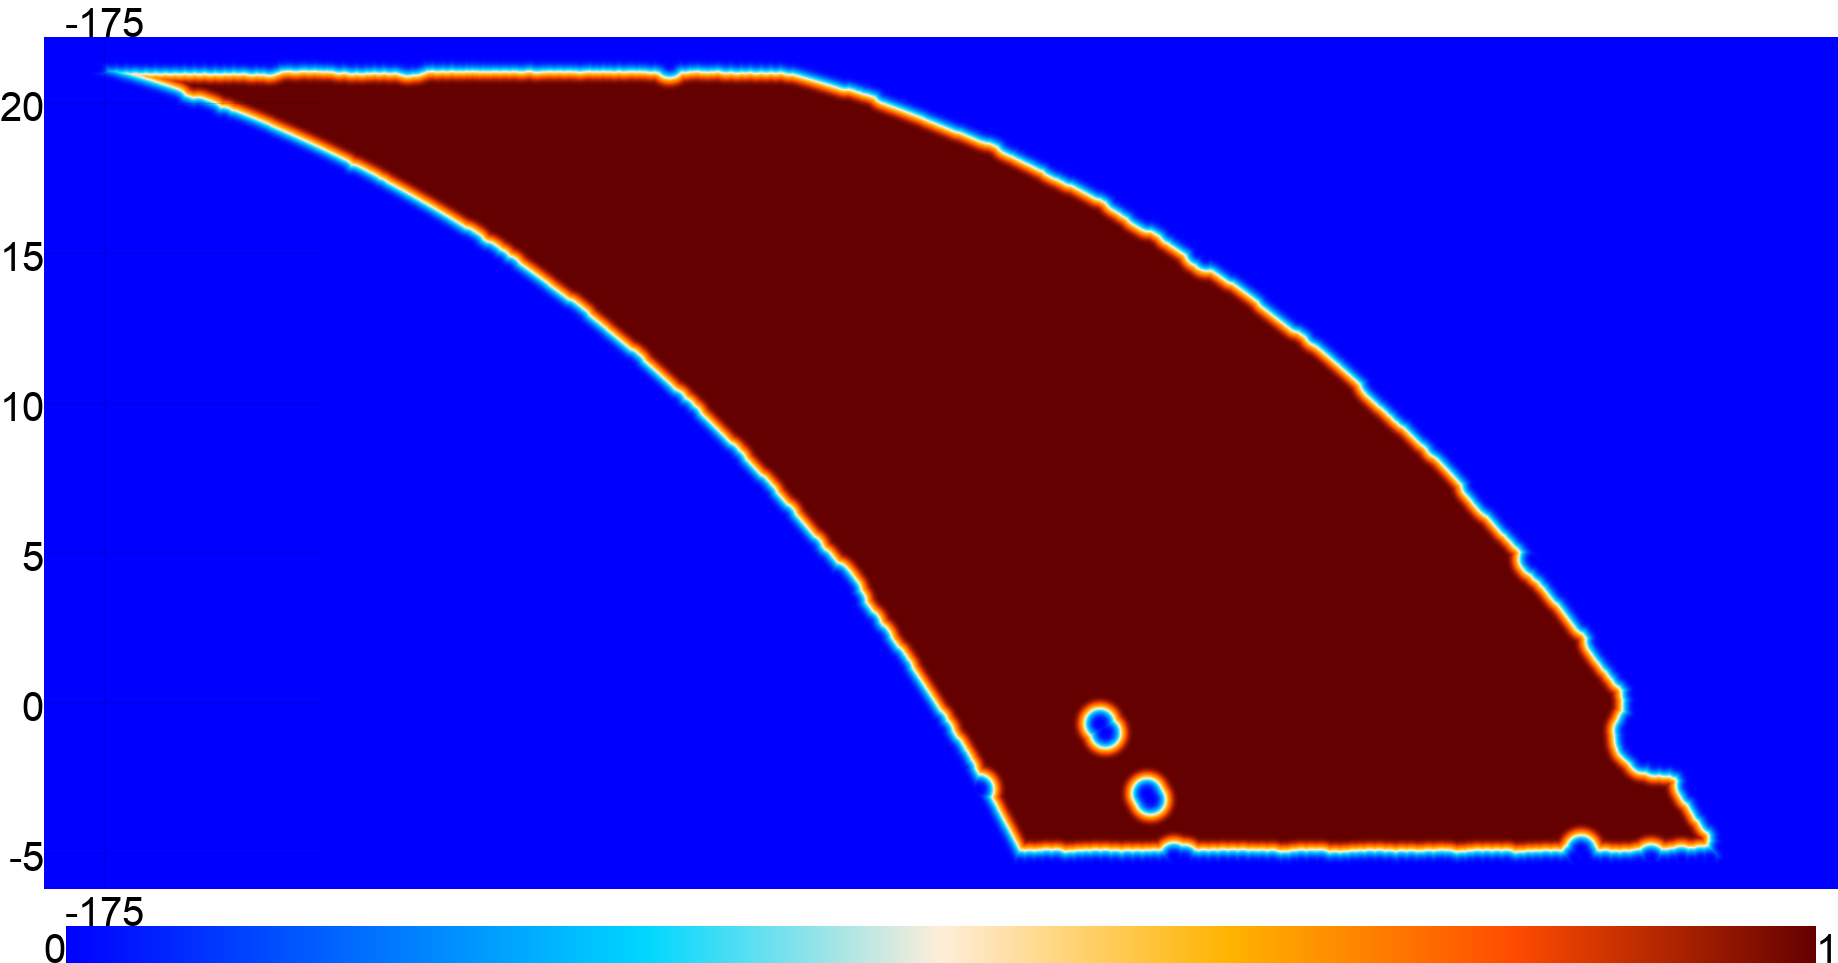

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [5:29:36<00:00,  3.96s/it]


Map name: depth1_1494463440_pa4_f150_map.fits
Pixell empirical correction factor:  0.341171271722817
w2: 0.33581580180667353
w2w4: 0.34284425609329683
f_sky w/w2w4: 0.013837504089267325


In [57]:
# For one of the depth-1 masks, generate pixell sims using alm from CAMB to compare
# the measured variance to the theoretical variance

# ell range 500-2500, bin size of 200, 5000 sims

# Doing the empirical correction all in pixell - just doing a single sim first and using that as the factor

indices = [0] # which depth-1 maps to use - testing a single map first
for idx in indices:
    depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
    depth1_T = enmap.read_map(depth1_path)[0]
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 1.0*enmap.read_map(ivar_path) # 1.0 for T noise - shouldn't matter here; we just want the ivar shape
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)
    
    #eshow(depth1_T, **keys_eshow)
    eshow(depth1_mask, **keys_eshow)

    # Steve's empirical correction factor from a quick pixell sim
    # Using bins of size ten here
    tmp_bins = np.arange(100,5001,10)
    tmp_digitized = np.digitize(ell[2:], tmp_bins, right=True)
    tmp_CAMB_ClTT_binned = np.bincount(tmp_digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(tmp_digitized)[1:-1]
    tmp_alm = hp.sphtfunc.synalm(ClTT)
    tmp_m = curvedsky.alm2map(tmp_alm, depth1_T, spin=[0])
    tmp_fm = enmap.map2harm(tmp_m*depth1_mask,normalize='phys')
    tmp_spectrum = np.real(tmp_fm*np.conj(tmp_fm))
    tmp_modlmap = tmp_fm.modlmap()
    tmp_digitized = np.digitize(np.ndarray.flatten(tmp_modlmap), tmp_bins, right=True)
    tmp_cl = np.bincount(tmp_digitized, tmp_spectrum.reshape(-1))[1:-1]/np.bincount(tmp_digitized)[1:-1]
    pix_corr_factor = np.mean(tmp_cl/tmp_CAMB_ClTT_binned)
    
    w2 = np.mean(depth1_mask**2)
    w2w4 = np.mean(depth1_mask**2)**2 / np.mean(depth1_mask**4)
    
    N_sims = 5000
    lmin = 500
    lmax = 2501
    bin_size = 200
    
    bins = np.arange(lmin, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.0
    
    spectra_corr_fac = []
    
    for i in tqdm(range(N_sims)):
        alm = hp.sphtfunc.synalm(ClTT)
        input_map = curvedsky.alm2map(alm, depth1_T, spin=[0])
        fourier_map = enmap.map2harm(input_map*depth1_mask,normalize='phys')
        binned_TT, bincount = spectrum_from_maps(fourier_map, fourier_map, b_ell_bin_1=1.0, \
                                             b_ell_bin_2=1.0, w2=pix_corr_factor, bins=bins)

        spectra_corr_fac.append(binned_TT)
        
    spectra_corr_fac = np.array(spectra_corr_fac)
    variance_corr_fac = np.var(spectra_corr_fac,axis=0)
    mean_corr_fac = np.mean(spectra_corr_fac, axis=0)
    
    # binning CAMB input to match my spectra
    digitized = np.digitize(ell[2:], bins, right=True)
    CAMB_ClTT_binned = np.bincount(digitized, ClTT[2:].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    
    theory_var_corr_factor = 2*CAMB_ClTT_binned**2/(bincount*pix_corr_factor)
    
    f_sky = get_hivon_fsky_enmap(depth1_mask)
    
    print("Map name: " + lines[idx])
    print("Pixell empirical correction factor: ", pix_corr_factor)
    print("w2: " + str(w2))
    print("w2w4: " + str(w2w4))
    print("f_sky w/w2w4: " +str(f_sky))

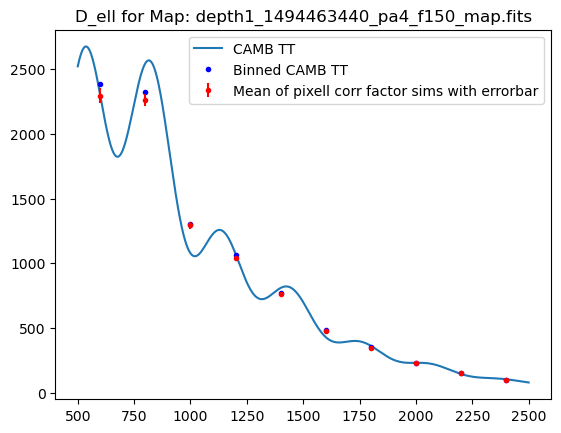

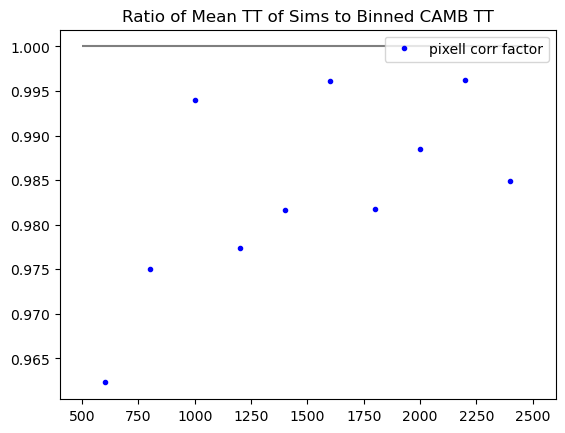

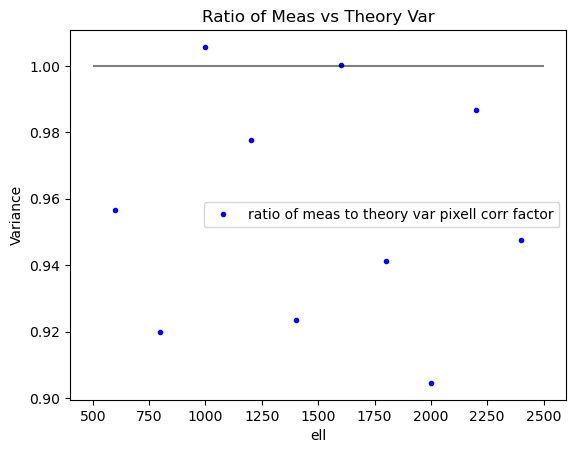

In [60]:
plt.plot(ell[500:2501],ell[500:2501]*(ell[500:2501]+1)*ClTT[500:2501]/(2*np.pi),label='CAMB TT')
plt.plot(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'b.',label='Binned CAMB TT')
plt.errorbar(centers,centers*(centers+1)*mean_corr_fac/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance_corr_fac)/(2*np.pi),fmt='r.',label='Mean of pixell corr factor sims with errorbar')
plt.title("D_ell for Map: " + lines[idx])
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(centers,mean_corr_fac/CAMB_ClTT_binned,'b.',label='pixell corr factor')
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.hlines(y=1.0,xmin=lmin,xmax=lmax,color='black',alpha=0.5)
plt.legend()
plt.show()
plt.close()

plt.plot(centers,variance_corr_fac/theory_var_corr_factor,'b.',label='ratio of meas to theory var pixell corr factor')
plt.legend()
plt.hlines(y=1.0,xmin=lmin,xmax=lmax,color='black',alpha=0.5)
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()